``````{warning} Requires optional libraries
:class: dropdown

This notebook requires a working installation of [GPAW](https://wiki.fysik.dtu.dk/gpaw/index.html). 

`````{tab-set}
````{tab-item} conda

Install GPAW using conda:
```{code-block}
conda install -c conda-forge gpaw
```
````
````{tab-item} pip

Install GPAW using pip:
```{code-block}
pip install gpaw
```
Install the PAW datasets into the folder `<dir>` using this command:
```{code-block}
gpaw install-data <dir>
```
````
`````

See [here](https://wiki.fysik.dtu.dk/gpaw/install.html) for detailed installation instructions.
``````

In [2]:
%config InlineBackend.rc = {"figure.dpi": 72, 'figure.figsize': (6.0, 4.0)}
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ase.build import graphene
from gpaw import GPAW

import abtem

abtem.config.set({"local_diagnostics.progress_bar": False});

(walkthrough:charge_density)=
# *ab initio* potentials with GPAW

The independent atom model (IAM) neglects bonding and the resulting charge transfer, this is typically a good approximation, because the core charge and electrons are responible for most of the potential. However, the difference between the IAM and a more realistic model including the effects of bonding is measurable, in certain systems{cite}`madsen_ab_initio`. Understanding this charge transfer may provide further insights, due its the importance in chemistry. 

Here we go beyond the independent atom model using density functional theory (DFT), to calculate a potential that includes charge transfer using GPAW{cite}`gpaw`. Note that you need a working GPAW installation to run the code in this walkthrough, see the [GPAW documentation](https://wiki.fysik.dtu.dk/gpaw/) for more information. abTEM only supports GPAW directly, however, other DFT codes may be used assuming that you can obtain the electron charge density as a numpy array through the `ChargeDensityPotential`.

## DFT calculation of hBN with GPAW
The first step to create a DFT potential is to converge a DFT calculation. We calculate the minimal hexagonal cell of hexagonal-Boron-Nitride (hBN). The atomic model is created by modifying a graphene model.

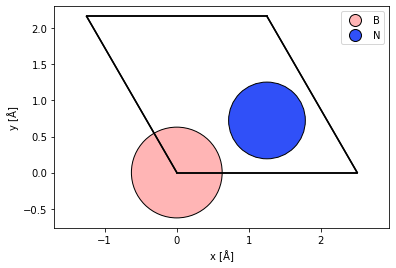

In [3]:
atoms = graphene(vacuum=3, a=2.504)

atoms[0].number = 5
atoms[1].number = 7

abtem.show_atoms(atoms, legend=True);

To run the DFT calculation, we use the `GPAW` calculator. We use the default parameters, except for the Brillouin zone sampling, which for a cell this small should be at least $5 \times 5 \times 3$.

In [4]:
gpaw = GPAW(txt=None, kpts=(5, 5, 1))
atoms.calc = gpaw

Running the method `get_potential_energy` triggers the DFT self-consistent field cycle to run, after which the `GPAW` object contains the converged PAW electron density.

In [5]:
atoms.get_potential_energy()

/opt/anaconda3/envs/jupyter-book/lib/python3.10/site-packages/gpaw/calculator.py:713: DeprecatedParameterWarning: Finite-difference mode implicitly chosen; it will be an error to not specify a mode in the future
  warnings.warn(


-19.36957650517081

```{warning}
DFT calculations can be extremely computationally intensive and may require massive parallelization. Hence, it may not be appropriate to run the DFT simulation in a notebook. Instead, we recommend exporting the converged GPAW calculator to a file, then importing it for your abTEM simulation.
```

## Using the GPAW potential in abTEM

It is straightforward to calculate a DFT potential from a converged GPAW calculation. The `GPAWPotential` object just requires a converged GPAW calculator.

In [6]:
potential_dft = abtem.GPAWPotential(gpaw, sampling=0.04).build().compute()

The `GPAWPotential` shares the same supertype as the standard potential, hence, they share most of their properties and methods.

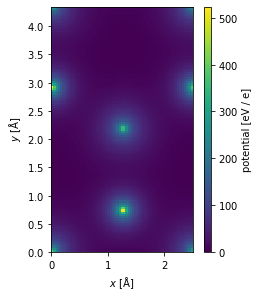

In [7]:
potential_dft.show(cbar=True);

## Comparing DFT to IAM

To show the difference that including charge trasnfer can have, we compare the DFT potential to an equivalent potential using the IAM. We make sure to set `projection="finite"` to ensure that the projection integrals are done identically.

In [8]:
atoms = gpaw.atoms

potential_iam = (
    abtem.Potential(atoms, gpts=potential_dft.gpts, projection="finite")
    .build()
    .compute()
)

Below compare the projection of the potentials. It is difficult to discern any visual differences between the IAM and DFT model from their resepective heatmaps, hence, we also calculate and show their difference and relative difference. In hBN the negative charge is transferred from Boron to Nitrogen, thus better screening the Nitrogen cores and lowering the potential.  

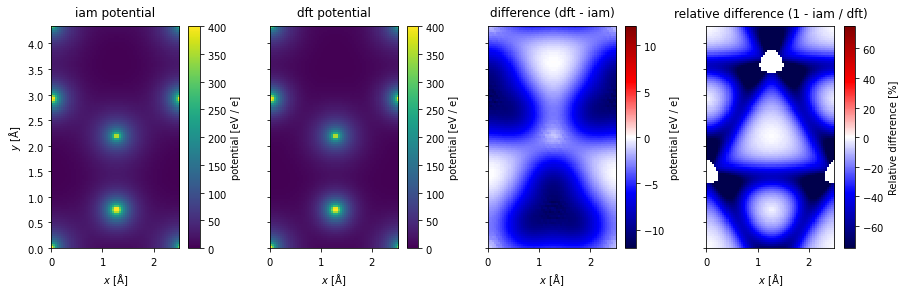

In [9]:
projected_potential_dft = potential_dft.project()
projected_potential_iam = potential_iam.project()

difference = projected_potential_dft - projected_potential_iam

relative_difference = projected_potential_dft.relative_difference(
    projected_potential_iam, min_relative_tol=0.001
)


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4), sharey=True)

projected_potential_iam.show(ax=ax1, cbar=True, title="iam potential", vmax=400)

projected_potential_dft.show(ax=ax2, cbar=True, title="dft potential", vmax=400)

difference.show(
    ax=ax3,
    cbar=True,
    title="difference (dft - iam)",
    vmin=-12,
    cmap="seismic",
    vmax=12,
)

relative_difference.show(
    ax=ax4,
    cmap="seismic",
    vmin=-75,
    vmax=75,
    cbar=True,
    title="relative difference (1 - iam / dft)",
)

for ax in (ax2, ax3, ax4):
    ax.set_ylabel("")

Comparing lineprofiles as below is often a preferable way of showing differences between two images. Below we show the lineprofiles of $x=0$.

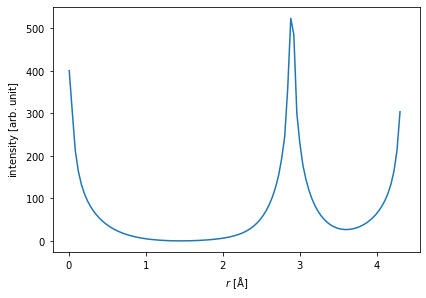

In [10]:
iam_line = projected_potential_iam.interpolate_line(
    start=(0, 0), end=(0, projected_potential_iam.extent[1])
)

dft_line = projected_potential_dft.interpolate_line(
    start=(0, 0), end=(0, projected_potential_dft.extent[1])
)

abtem.stack([iam_line, dft_line], ("IAM", "DFT")).show();

## Electron diffraction of DFT potentials

Next, we calculate the influence of charge transfer on the electron diffraction patterns in hBN, approximately reproducing a published result {cite}`gpawpotentials`.

We create a `PlaneWave` at an energy of $100 \ \mathrm{keV}$, then run the multislice algorithm for the IAM and DFT potential, finally caluclating the diffraction patterns.

In [23]:
planewave = abtem.PlaneWave(energy=100e3)

diffraction_iam = (
    planewave.multislice(potential_iam)
    .diffraction_patterns(block_direct=True, max_angle=50)
    .compute()
)
diffraction_dft = (
    planewave.multislice(potential_dft)
    .diffraction_patterns(block_direct=True, max_angle=50)
    .compute()
)

stacked = abtem.stack([diffraction_iam, diffraction_dft], ("iam", "dft"))

diffraction_spots = stacked.index_diffraction_spots(atoms, threshold=0.00001)

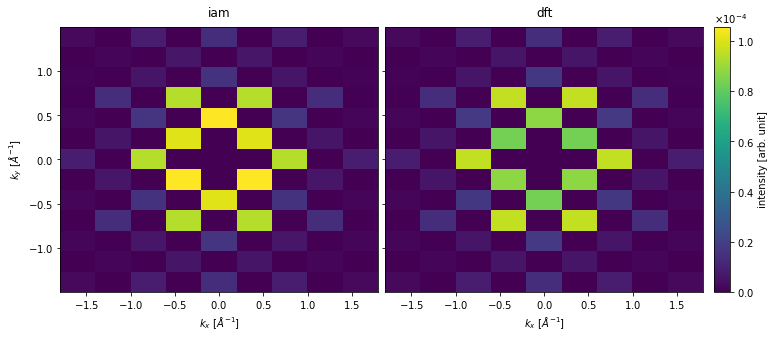

In [24]:
stacked.show(explode=True, common_color_scale=True, cbar=True, figsize=(12, 6));

We show the resulting diffraction patterns below. The most obvious difference is that order of intensity of the $(200)$ and $(110)$ families of diffraction spots is flipped in the two models. 

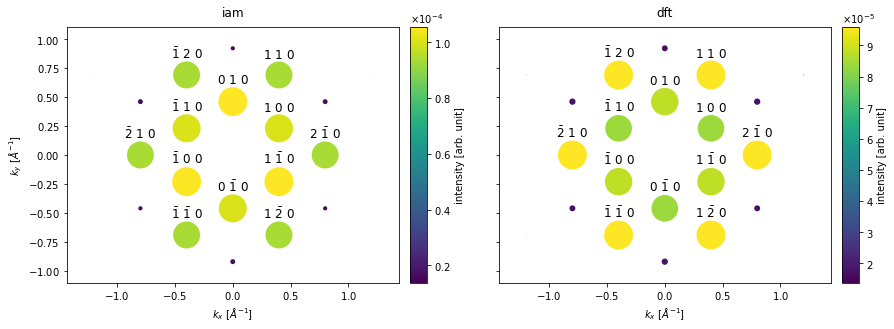

In [25]:
visualization = diffraction_spots.show(
    explode=True, common_color_scale=False, cbar=True, figsize=(14, 6), scale=.5
)

visualization.set_miller_index_annotations(threshold=5e-5, size=12)

Below we compare the relative intensities of the diffraction spots in a table, the intensities are normalized to the intensity of the $(110)$ spots. We also include experimental values `cite`{gpawpotential}.

We see the largest difference between the models for the $(200)$ spots. Comparing to the experimental result, we see that IAM predicts the wrong intensity ordering of the $(110)$ and $(200)$ spots. The DFT model gets the order of the spots right, however, the relative intensity is significantly overestimated. The main cause of the discrepancy is the noninclusion of phonon scattering, as we shall see in the following section. 

In [ ]:
diffraction_spots.to_dataframe()

## Frozen phonons and DFT

:::{admonition} {material-regular}`engineering;1.5rem;sd-mr-1` Currently Under Construction
:class: no-icon
Check back for more...
:::